## Face Recognition with Custom Dataset and Deep Learning

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset
from tqdm.auto import tqdm


c:\Users\Sibsankar De\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Facerecognition Dataset preparation

In [2]:
class FaceRecognitionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.label_map = {}

        # Assign one label per folder (001_frontal, 002_frontal, etc.)
        all_folders = sorted([f for f in self.root_dir.iterdir() if f.is_dir()])
        for label_idx, person_folder in enumerate(all_folders):
            identity = person_folder.name
            self.label_map[identity] = label_idx

            # Get all image files in this identity folder (including distortion subfolder)
            for image_path in person_folder.glob("*.jpg"):
                self.image_paths.append(image_path)
                self.labels.append(label_idx)

            distortion_folder = person_folder / "distortion"
            if distortion_folder.exists():
                for distorted_image in distortion_folder.glob("*.jpg"):
                    self.image_paths.append(distorted_image)
                    self.labels.append(label_idx)

        self.classes = list(self.label_map.keys())

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


### Transforms and Dataloaders

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

train_dataset = FaceRecognitionDataset(root_dir='./data-set/Task_B/train', transform=transform)
val_dataset = FaceRecognitionDataset(root_dir='./data-set/Task_B/val', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

num_classes = len(train_dataset.label_map)
print("Total Classes:", num_classes)


Total Classes: 877


### Model Definition

In [4]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\Sibsankar De\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sibsankar De\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Training Setup

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Training Loop

In [25]:
def train_model(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    loop = tqdm(loader, desc="Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        labels = labels.long()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        loop.set_postfix(loss=loss.item())

    avg_loss = running_loss / len(loader.dataset)
    return avg_loss 


### Validation Loop

In [26]:
def evaluate_model(model, dataloader, device, dataset_name="Dataset"):
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    # Classification Report
    print(f"\nClassification Report ({dataset_name}):")
    try:
        print(classification_report(targets, preds, target_names=["male", "female"]))
    except ValueError:
        print(classification_report(targets, preds))  # fallback for multi-class

    # Confusion Matrix
    cm = confusion_matrix(targets, preds)
    sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {dataset_name}")
    plt.show()

    return preds, targets

### Training Process
This step is to train the model. 

In [27]:
EPOCHS = 10

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    train_loss = train_model(model, train_loader, criterion, optimizer, device)
    print(f"Train Loss: {train_loss:.4f}")

# Save the final trained model
torch.save(model.state_dict(), "best_face_model.pth")
print("✅ Training complete. Model saved to best_face_model.pth")



Epoch 1/10


Train Loss: 0.0020

Epoch 2/10


Train Loss: 0.0015

Epoch 3/10


Train Loss: 0.0011

Epoch 4/10


Train Loss: 0.0008

Epoch 5/10


Train Loss: 0.0006

Epoch 6/10


Train Loss: 0.0005

Epoch 7/10


Train Loss: 0.0004

Epoch 8/10


Train Loss: 0.0003

Epoch 9/10


Train Loss: 0.0002

Epoch 10/10


Train Loss: 0.0002
✅ Training complete. Model saved to best_face_model.pth


### Evaluation

C:\Users\Sibsankar De\AppData\Local\Temp\ipykernel_104508\1270363259.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_face_model.pt


Classification Report (Validation):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.00      0.00      0.00         8
           2       0.00      0.00      0.00         8
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         8
           5       0.00      0.00      0.00         8
           6       0.00      0.00      0.00         8
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00         8
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         8
          12       0.00      0.00      0.00         8
          13       0.00      0.00      0.00         8
          14       0.00      0.00      0.00         8
          15       0.00      0.00      0.00         8
          16       0.00      0.00      0.00 

c:\Users\Sibsankar De\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sibsankar De\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sibsankar De\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

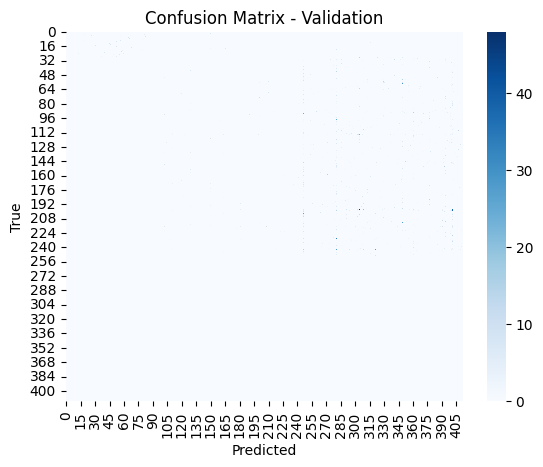


Classification Report (Training):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         8
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00         8
           8       1.00      1.00      1.00         8
           9       1.00      1.00      1.00         8
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         8
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00         8
          14       1.00      1.00      1.00         8
          15       1.00      1.00      1.00         8
          16       1.00      1.00      1.00   

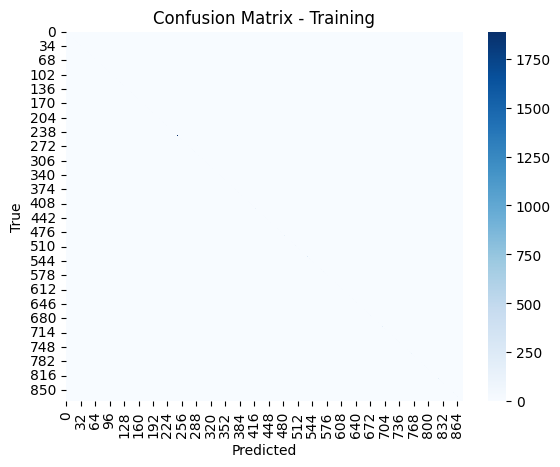

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("best_face_model.pth"))
model.to(device)

val_preds, val_targets = evaluate_model(model, val_loader, device, "Validation")
train_preds, train_targets = evaluate_model(model, train_loader, device, "Training")

### Run this function with Image path to predict image details

In [30]:
def predict_image(model, image_path, transform, label_map, device):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Ensure model is on the correct device
    model.to(device)
    model.eval()

    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).item()

    # Get class name from label map
    class_name = {v: k for k, v in label_map.items()}.get(pred, "Unknown")
    return class_name

### example of usage - 

```bash
label_map = {
    "frontal_0001": 0,
    "frontal_0002": 1,
    "frontal_0003": 2,
    ...
}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

predicted_class = predict_image(model, "sample.jpg", transform, label_map, device)
print("Predicted Class:", predicted_class)
```